# VarClump1D: Study of Parameters 

In [50]:
%matplotlib inline

import sys
import numpy as np
import scipy as sp
import sympy as sym
import numexpr as ne
import matplotlib.pyplot as plt
from scipy import interpolate, optimize
from EulerLagrange1D import *

#import of acalib helper functions
sys.path.append('../../ACALIB/')
from acalib import acontainer as ac

## Loading data 1D from center pixel of cube

In [51]:
"""
Loading data
"""
cont = ac.AContainer()
#cont.load('../../bindata/fits/cubes/Antennae_North.CO3_2Line.Clean.pcal1.image.fits')
#cont.load('../../bindata/fits/cubes/Antennae_South.CO3_2Line.Clean.pcal1.image.fits')
#cont.load('../../bindata/fits/cubes/CenA.CO2_1Line.Clean.image.fits')
cont.load('../../bindata/fits/cubes/M100line.image.fits')
#cont.load('../../bindata/fits/cubes/Orion.methanol.cbc.contsub.image.fits')

cube = cont.primary
spar = cube.standarize()
data = cube.data

INFO: Processing HDU 0 (Image) [acalib.io.formats]
INFO: 4D data detected: assuming RA-DEC-FREQ-STOKES (like CASA-generated ones), and dropping STOKES [acalib.io.formats]


In [52]:
"""
Generating the data function
"""
f_data = data[:,300,300]
f_data /= np.max(f_data)
x = np.linspace(0., 1., len(f_data), endpoint=True)
g = sp.interpolate.interp1d(x, f_data, kind='linear')
x_ = np.linspace(0., 1., 25*len(f_data), endpoint=True)

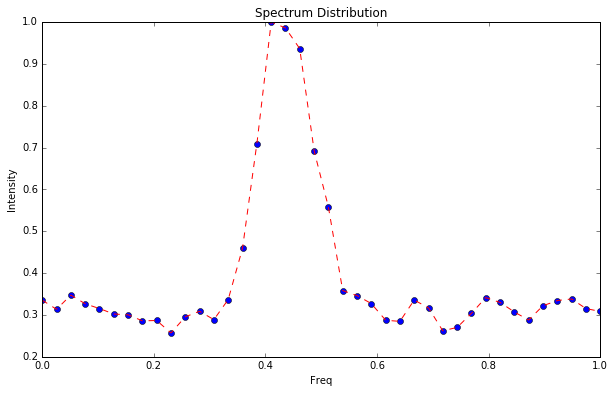

In [53]:
plt.figure(figsize=(10,6))
plt.plot(x, f_data, 'bo', x_, g(x_), 'r--')
plt.title('Spectrum Distribution')
plt.xlabel('Freq')
plt.ylabel('Intensity')
plt.show()

## Thing Gaussian Perturbation

In [54]:
def gaussian(x, x0=0.8, sig0=0.01):
    return (0.7)*np.exp(-(x-x0)**2/(sig0**2))

In [55]:
"""
New function data
"""
def f(x): return g(x)+gaussian(x)

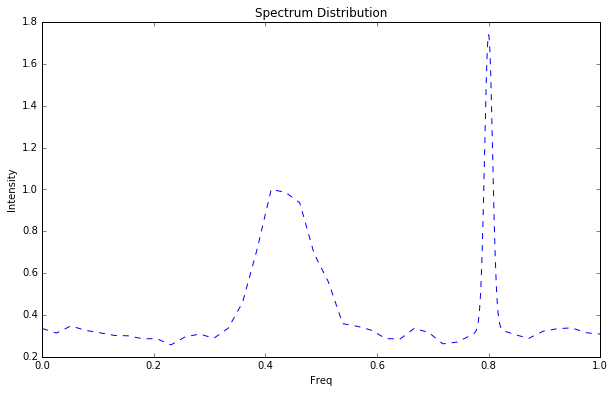

In [56]:
plt.figure(figsize=(10,6))
plt.plot(x_, f(x_)+gaussian(x_), 'b--')
plt.title('Spectrum Distribution')
plt.xlabel('Freq')
plt.ylabel('Intensity')
plt.show()

In [57]:
"""
HELPER FUNCTIONS TO VISUALIZE AND COMPARE SOLUTIONS
"""
def compare_plot(c, sig, xc, resolution=10, title=None, evaluation=True, center=False):
    N = np.size(xc)
    _xe = np.linspace(0., 1., 10*N, endpoint=True)
    _Dx = np.empty((10*N,N))
    for k in range(10*N):
        _Dx[k,:] = (_xe[k] - xc)

    phi_m = phi(_Dx, sig)
    u = np.dot(phi_m, c**2)
    plt.figure(figsize=(10,6))
    plt.plot(_xe, u, 'r-', label='Solution')
    plt.plot(x_, f(x_)+gaussian(x_), 'b--', label='Data')
    if evaluation: plt.plot(xe, f(xe)+gaussian(xe), 'go', label='Evaluation points')
    if center: plt.plot(xc, f(xc)+gaussian(xc), 'ro', label='Center points')
    plt.title(title)
    plt.legend(bbox_to_anchor=(1.3, 1.0))
    plt.show()

## Centers and evaluation points

In [59]:
#number of gaussians
N = 50

""" Computing center points """
xc = np.linspace(0., 1., N+2, endpoint=True)[1:-1]
print('Center points:')
print(xc)
print('---------------------------------------------')

""" 
Computing evaluation points, i.e, points where
EL equation will be evaluated
"""
xe = np.linspace(0., 1., 2*N, endpoint=True)[1:-1]
print('Evaluation points:')
print(xe)
print('---------------------------------------------')

Center points:
[ 0.01960784  0.03921569  0.05882353  0.07843137  0.09803922  0.11764706
  0.1372549   0.15686275  0.17647059  0.19607843  0.21568627  0.23529412
  0.25490196  0.2745098   0.29411765  0.31372549  0.33333333  0.35294118
  0.37254902  0.39215686  0.41176471  0.43137255  0.45098039  0.47058824
  0.49019608  0.50980392  0.52941176  0.54901961  0.56862745  0.58823529
  0.60784314  0.62745098  0.64705882  0.66666667  0.68627451  0.70588235
  0.7254902   0.74509804  0.76470588  0.78431373  0.80392157  0.82352941
  0.84313725  0.8627451   0.88235294  0.90196078  0.92156863  0.94117647
  0.96078431  0.98039216]
---------------------------------------------
Evaluation points:
[ 0.01010101  0.02020202  0.03030303  0.04040404  0.05050505  0.06060606
  0.07070707  0.08080808  0.09090909  0.1010101   0.11111111  0.12121212
  0.13131313  0.14141414  0.15151515  0.16161616  0.17171717  0.18181818
  0.19191919  0.2020202   0.21212121  0.22222222  0.23232323  0.24242424
  0.25252525  0.26

## Initial conditions

In [60]:
"""
Defining initial parameter values
"""
c0 = np.sqrt(f(xc)/N)
sig0 = (1./(N))*np.ones(N)

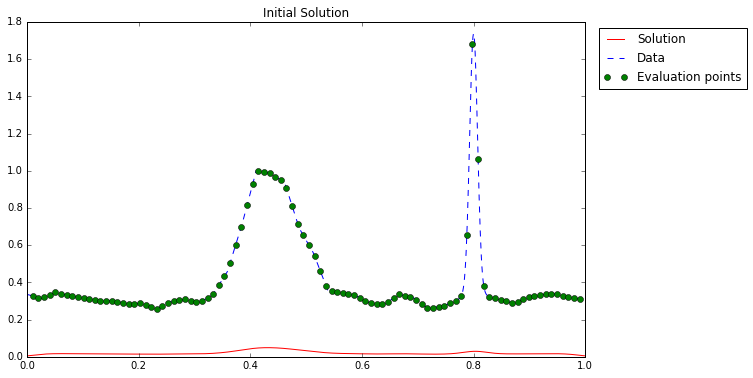

In [61]:
"""
Visualizing the 'initial' solution
"""
compare_plot(c0, sig0, xc, title='Initial Solution')

In [78]:
"""
SOLVE FUNCTIONS TO HANDLE ELFunc2 INSTANCES
"""
def solve(elf, n_iter=5, verbose=True):
    for i in range(n_iter):
        #solve for c
        sol = sp.optimize.root(elf.F1, elf.c, method='lm', options={'maxiter':10000})
        opt_c = sol.x
        delta_c = np.linalg.norm(opt_c-elf.c)
        elf.set_c(opt_c)
        title = 'Best solution at iter={0} and improved c'.format(i)
        compare_plot(elf.c, elf.sig, elf.xc, title=title, evaluation=False, center=True)
        print('Variation on c={0}'.format(delta_c))
        print('\nnfev: {0}'.format(sol['nfev']))
        print('\nmessage: {0}'.format(sol['message']))
        print('\nsuccess: {0}'.format(sol['success']))
        print('------------------------------------------------------------')

        #solve for sig
        sol = sp.optimize.root(elf.F2, elf.sig, method='lm', options={'maxiter':10000})
        opt_sig = sol.x
        delta_sig = np.linalg.norm(opt_sig-elf.sig)
        elf.set_sig(opt_sig)
        title = 'Best solution at iter={0} and improved sig'.format(i)
        compare_plot(elf.c, elf.sig, elf.xc, title=title, evaluation=False, center=True)
        print('Variation on sig={0}'.format(delta_sig))
        print('\nnfev: {0}'.format(sol['nfev']))
        print('\nmessage: {0}'.format(sol['message']))
        print('\nsuccess: {0}'.format(sol['success']))
        print('-------------------------------------------------------------')

In [79]:
"""
Instantiating the EL func object
"""
elf0 = ELFunc2(f, xe, xc, c0, sig0, d1psi1=d1psi, d2psi2=d2psi, a=0., b=0.)
elf1 = ELFunc2(f, xe, xc, c0, sig0, d1psi1=d1psi, d2psi2=d2psi, a=1, b=0., lamb1=5.)
elf2 = ELFunc2(f, xe, xc, c0, sig0, d1psi1=d1psi, d2psi2=d2psi, a=1., b=0.001, lamb1=5., lamb2=0.7)

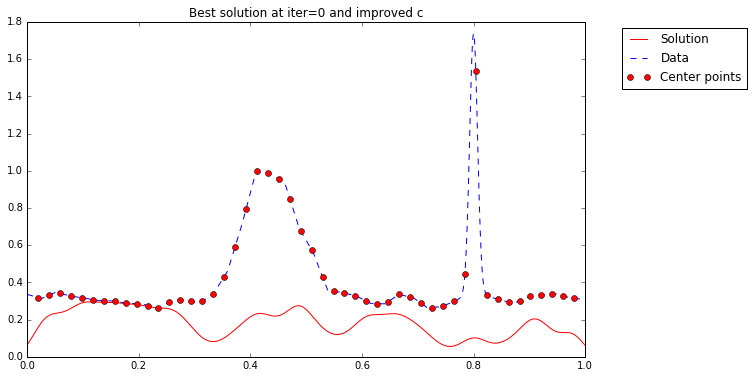

Variation on c=1.32975615544

nfev: 1851

message: The relative error between two consecutive iterates is at most 0.000000

success: True
------------------------------------------------------------


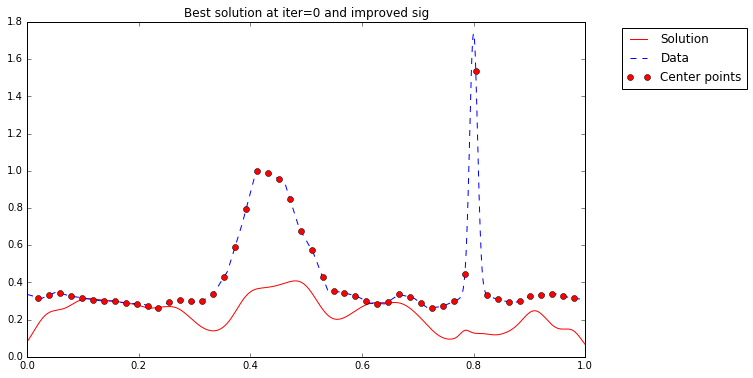

Variation on sig=0.144202765135

nfev: 2003

message: The relative error between two consecutive iterates is at most 0.000000

success: True
-------------------------------------------------------------


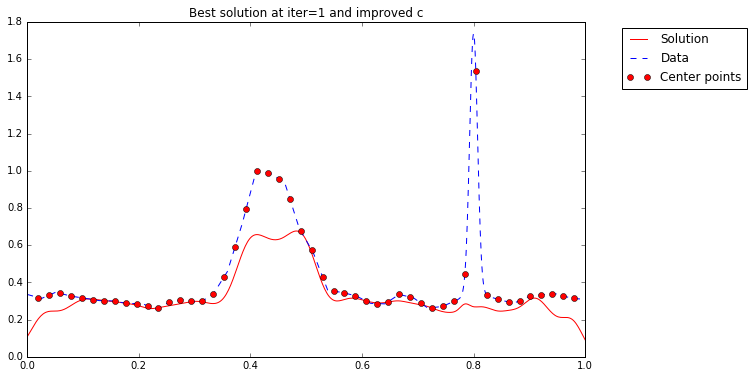

Variation on c=0.512094919435

nfev: 988

message: The relative error between two consecutive iterates is at most 0.000000

success: True
------------------------------------------------------------


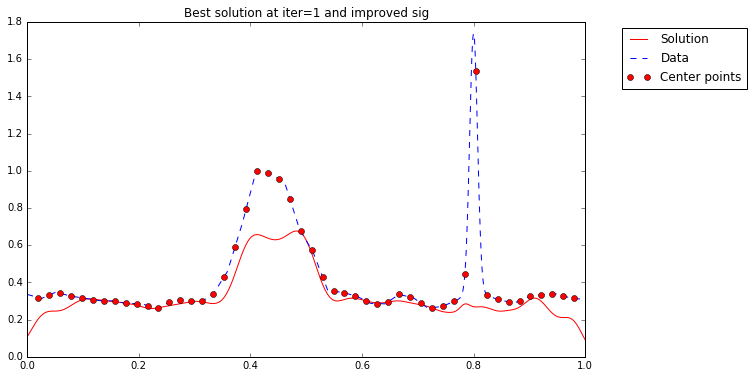

Variation on sig=3.68330337031e-08

nfev: 219

message: The relative error between two consecutive iterates is at most 0.000000

success: True
-------------------------------------------------------------


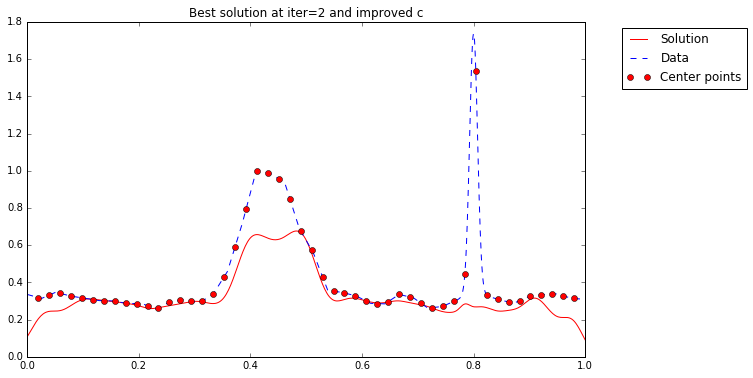

Variation on c=6.69887528079e-08

nfev: 64

message: The relative error between two consecutive iterates is at most 0.000000

success: True
------------------------------------------------------------


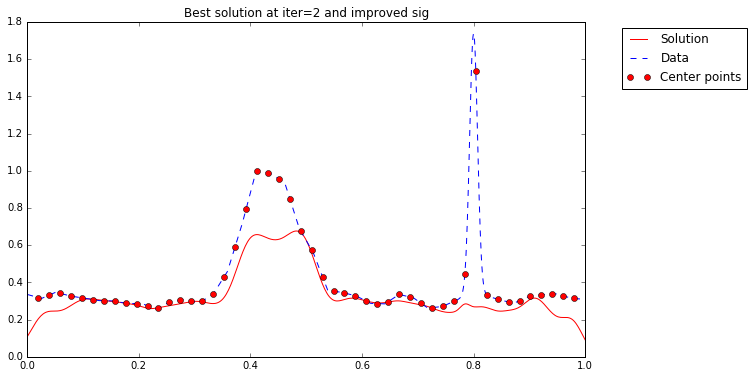

Variation on sig=5.02704565246e-08

nfev: 273

message: The relative error between two consecutive iterates is at most 0.000000

success: True
-------------------------------------------------------------


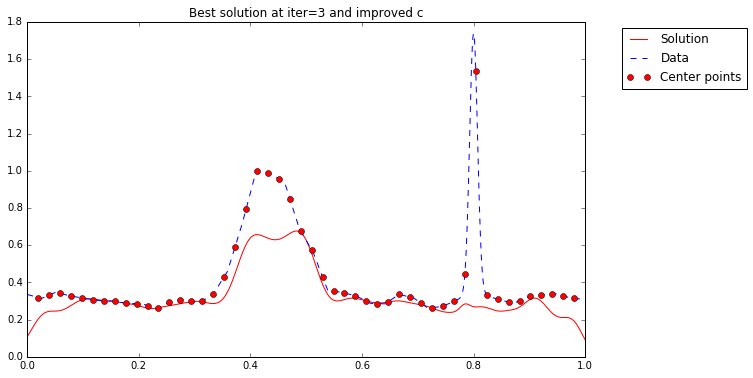

Variation on c=0.0

nfev: 64

message: The relative error between two consecutive iterates is at most 0.000000

success: True
------------------------------------------------------------


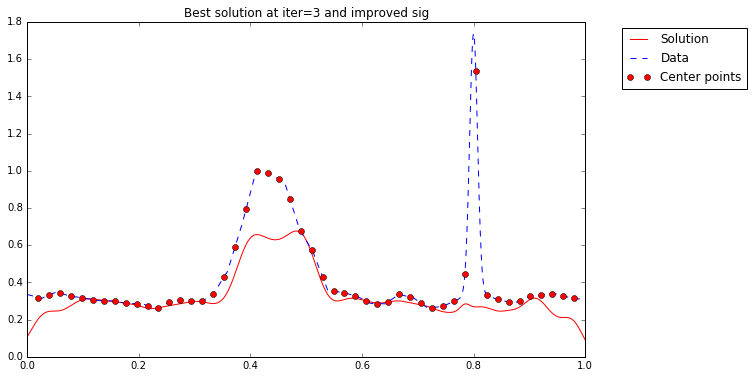

Variation on sig=0.0

nfev: 66

message: The relative error between two consecutive iterates is at most 0.000000

success: True
-------------------------------------------------------------


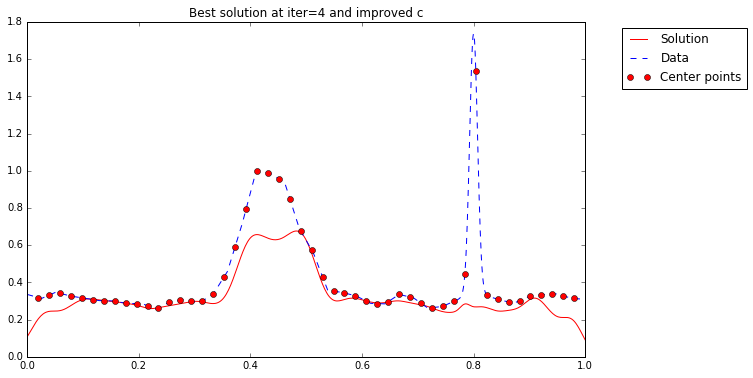

Variation on c=0.0

nfev: 64

message: The relative error between two consecutive iterates is at most 0.000000

success: True
------------------------------------------------------------


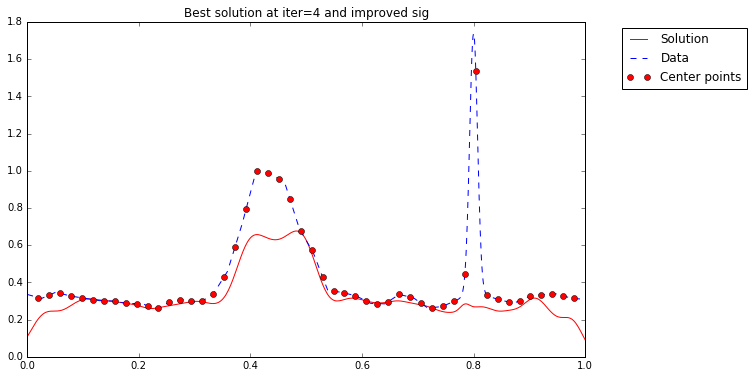

Variation on sig=0.0

nfev: 66

message: The relative error between two consecutive iterates is at most 0.000000

success: True
-------------------------------------------------------------


In [80]:
solve(elf2)

In [65]:
"""
Instantiating the EL func object
"""
elf3 = ELFunc1(f, xe, xc, c0, sig0, d1psi1=d1psi, d2psi2=d2psi, a=0., b=0.)
elf4 = ELFunc1(f, xe, xc, c0, sig0, d1psi1=d1psi, d2psi2=d2psi, a=.2, b=0., lamb1=5.)
elf5 = ELFunc1(f, xe, xc, c0, sig0, d1psi1=d1psi, d2psi2=d2psi, a=.2, b=0.0001, lamb1=5., lamb2=1.)
elf_list = [elf3, elf4, elf5]

In [66]:
#solve it!
elf = elf_list[0]
sol = sp.optimize.root(elf.F, np.concatenate([elf.c, elf.sig]), method='hybr', options={'maxfev':10000})
op_c = sol.x[0:N]
op_sig = sol.x[N:]
print('fun:\n {0}'.format(sol['fun']))
print('\nnfev: {0}'.format(sol['nfev']))
print('\nmessage: {0}'.format(sol['message']))
print('\nsuccess: {0}'.format(sol['success']))
print('\nop_c:\n {0}'.format(op_c))
print('\nop_c_squared:\n {0}'.format(op_c**2))
print('\nop_sig:\n {0}'.format(op_sig))
print('-------------------------------------------------------------------')

fun:
 [ -5.09181687e-02   2.96291670e-02   1.52742267e-02   4.19072342e-03
  -1.45779433e-02  -1.10168957e-03   9.51049245e-03   1.29175610e-02
   9.49911925e-03   5.49635060e-03   3.12991920e-03   1.86099938e-03
  -7.42406733e-04  -7.24150925e-03  -1.09960243e-02  -4.74305947e-03
   5.32734334e-03   1.33365262e-02   1.21544100e-02   1.05513509e-02
   2.49946079e-02   4.61306847e-02   5.84040252e-02   2.48400726e-02
  -8.35567709e-03  -2.83477843e-02  -3.93267927e-02  -4.66406155e-02
  -2.17939027e-05  -3.71672876e-03  -8.58761177e-04  -8.46689384e-03
   6.36745729e-03  -6.59565873e-03   1.73471952e-02   3.28473880e-02
   2.51168572e-02   3.28886573e-02   4.25899834e-03  -5.23260094e-02
  -5.96263015e-02   2.56427249e-02   5.02435966e-02   4.15442581e-02
  -9.25376590e-03  -4.61378918e-02   1.58874940e-03   3.84319050e-02
   1.42170083e-02  -1.37835744e-02  -3.64668536e-02  -1.47146434e-02
   4.78412933e-02   4.26682789e-02   1.27841126e-02  -3.34825287e-03
  -7.24186724e-03  -7.391966

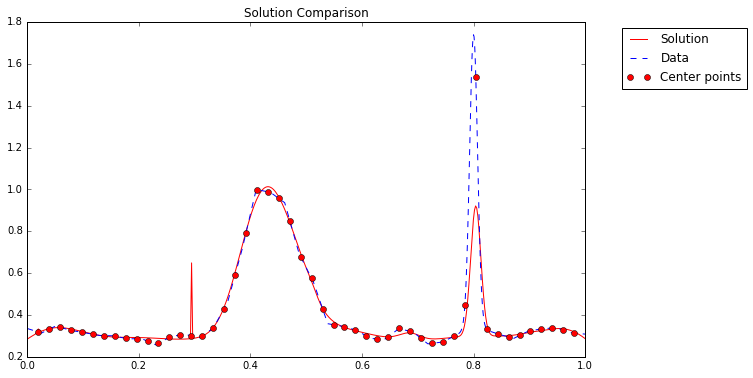

In [67]:
compare_plot(op_c, op_sig, xc, title='Solution Comparison', evaluation=False, center=True)